# TWAP implementation
_Version 1.0_

In [28]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# load our helper functios
%run simtools.py

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )

### Load Merged Data

We'll assume we have already done some cleaning by using our Tick Data Setup or similar code

In [2]:
# set up some variables
tickfile = 'TSLA-TAQ-aug19.zip'
test_day = '2019-08-30'

In [3]:
# load tick data
taq = pd.read_pickle(tickfile)

In [4]:
len(taq)

10313405

In [5]:
taq.tail()

,exch,bid_px,bid_size,ask_px,ask_size,symbol,suffix_x,suffix_y,trade_size,trade_px
2019-08-30 15:59:59.991016490,Z,225.55,1.0,225.62,1.0,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.991034985,Z,225.56,1.0,225.62,1.0,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.991902659,Z,225.56,1.0,225.62,2.0,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.993930363,Z,225.56,1.0,225.62,1.0,TSLA,NaN,NaN,NaN,NaN
2019-08-30 15:59:59.994803816,Z,225.56,1.0,225.62,2.0,TSLA,NaN,NaN,NaN,NaN


In [6]:
# filter on date
day = taq[test_day]

In [13]:
day.head()

,exch,bid_px,bid_size,ask_px,ask_size,symbol,suffix_x,suffix_y,trade_size,trade_px
2019-08-30 09:30:00.000435733,K,229.0,11.0,230.00,12.0,TSLA,NaN,NaN,NaN,NaN
2019-08-30 09:30:00.000507173,Z,229.4,1.0,230.50,4.0,TSLA,NaN,NaN,NaN,NaN
2019-08-30 09:30:00.001223950,Q,229.0,19.0,229.79,3.0,TSLA,NaN,NaN,NaN,NaN
2019-08-30 09:30:00.139723704,Z,229.4,1.0,230.50,4.0,TSLA,NaN,NaN,NaN,NaN
2019-08-30 09:30:00.139732326,Z,229.4,1.0,230.50,4.0,TSLA,NaN,NaN,NaN,NaN


## Main Processing Loop

In [38]:
# order parameters will go here
order_side = 'b'
quantity = 1000000
minutes_to_trade = 390
slice_size = quantity / minutes_to_trade

# ACCUMULATORS AND MARKET STATE DATA
# initialize some counters
quantity_remaining = quantity
current_bar = 0

# hold completed trades 
trade_data = pd.DataFrame( columns = [ 'price' , 'shares' ], index=day.index )

# init our price and volume variables
[last_price, last_size, bid_price, bid_size, ask_price, ask_size, volume] = np.zeros(7)

# maybe a couple more
[trade_count, quote_count] = [0, 0]

# cumulative volume is nice to have too
cumulative_volume = 0

# main event loop
log_msg('starting main loop')
for index, row in day.iterrows() :
    # get each row: is it a quote or a trade?
    if pd.isna(row.trade_px): # it's a quote
        bid_price = row.bid_px
        bid_size = row.bid_size
        ask_price = row.ask_px
        ask_size = row.ask_size
        quote_count += 1
    else: # it's a trade
        last_price = row.trade_px
        last_size = row.trade_size
        trade_count += 1
        cumulative_volume += row.trade_size
    
    # algo code goes here
    # TODO: FIX ALL THIS
    # figure out which minute we are in after the open
    time_from_open = ( index - pd.Timedelta( hours = 9, minutes = 30 ) )
    minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
    
    # are we in a new minute?
    if ( minutes_from_open > current_bar ):
        # increment our bar counter
        current_bar = minutes_from_open
        
        # we should do a trade
        if order_side == 'b':
            # buy on the offer
            new_trade_price = ask_price
            new_trade_size = slice_size
            
            # Accumulate the trade per bin
            trade_data.loc[index] = [new_trade_price, new_trade_size]
            
            #print("buy: {0:f} shares at {1:.2f}".format(new_trade_size, new_trade_price))
            
        else: # it's a sell
            # sell on the bid
            new_trade_price = bid_price
            new_trade_size = slice_size
    
            # Accumulate the trade per bin
            trade_data.loc[index] = [new_trade_price, new_trade_size]
            
            #print("sell: {0:f} shares at {1:.2f}".format(new_trade_size, new_trade_price))
    
        # decrement the remaining qty, and bail out if it's zero
        quantity_remaining -= slice_size
    
    # debug
    #print( str(volume) + " " + str(new_trade) + " " + str(quantity_remaining) )
    
    if ( quantity_remaining <= 0 ):
        print(quantity_remaining)
        break
    
log_msg('end main loop')

starting main loop : 2019-09-25 00:10:33:909571
end main loop : 2019-09-25 00:12:54:527521


In [22]:
print("total quote messages: {:,}".format(quote_count))
print("total trade messages: {:,}".format(trade_count))
print("total shares trades: {:,}".format(cumulative_volume))

total quote messages: 433,338
total trade messages: 83,663
total shares trades: 8,419,878.0


### Summary Stats of TWAP Order

In [25]:
# average trade price
pavg = ( trade_data[ 'price' ] * trade_data[ 'shares' ] ).sum() /  trade_data[ 'shares' ].sum()

#slippage =  ( ( vwap - pavg ) / vwap ) * 10000

# calculate VWAP
#vwap = ( day['close'] * day['volume'] ).sum() / day['volume'].sum()

#slippage =  ( ( vwap - pavg ) / vwap ) * 10000

print( "Avg Price: {:.4f}".format(pavg) )
#print( "VWAP: {:.4f}".format(vwap) )
#print( "Performance vs Day VWAP in bps: {:.4f}".format(slippage) )

Avg Price: 226.6456


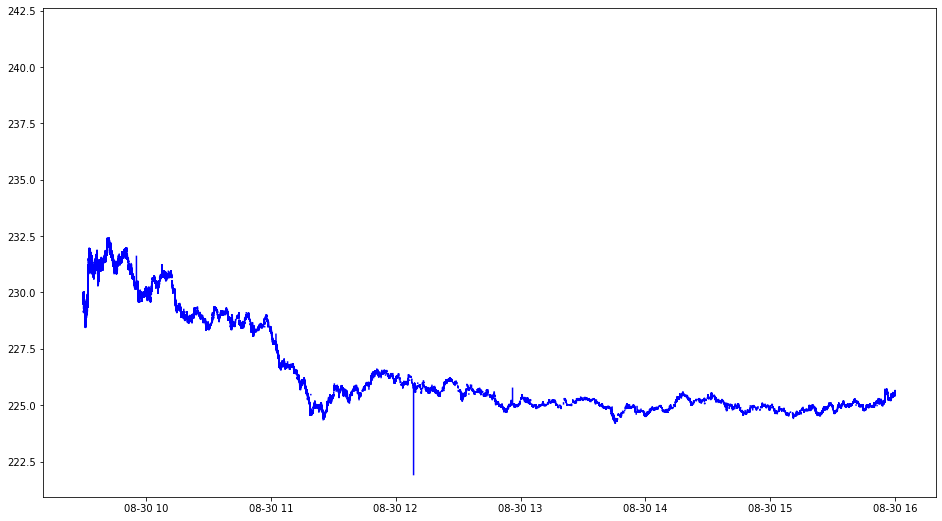

In [33]:
# let's see what we got
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(day.trade_px, 'b-')
ax.plot(trade_data.price, 'r-')
plt.show()

In [36]:
trade_data[pd.notna(trade_data.price)]

,price,shares
2019-08-30 09:32:00.000806860,229.95,2564.1
2019-08-30 09:33:00.032543152,231.73,2564.1
2019-08-30 09:34:00.000838649,231.33,2564.1
2019-08-30 09:35:00.007770713,230.88,2564.1
2019-08-30 09:36:00.005515785,231.58,2564.1
...,...,...
2019-08-30 15:55:00.027744107,238.51,2564.1
2019-08-30 15:56:00.015945707,225.66,2564.1
2019-08-30 15:57:00.182101628,225.3,2564.1
2019-08-30 15:58:00.060857737,225.41,2564.1
